# Spoken Digit Recognition

Input - speech signal, output - digit number

Approach:

1. Read and Preprocess the data. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network.
4. Creating the augmented data and doing step 2 and 3 again.

## Loading Data

In [ ]:
import numpy as np
import pandas as pd
import librosa
import os
##if you need any imports you can do that here. 

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [ ]:
#import dependency to extract recordings.zip
from zipfile import ZipFile

In [ ]:
#download recordings.zip from gdrive using id 
!gdown 17YGQheavMbM6aeHYjUcGssXfb7eQHo1z

Downloading...
From: https://drive.google.com/uc?id=17YGQheavMbM6aeHYjUcGssXfb7eQHo1z
To: /content/recordings.zip
100% 9.28M/9.28M [00:00<00:00, 32.9MB/s]


In [ ]:
with ZipFile('/content/recordings.zip','r') as zip:
    all_files = zip.namelist()
    zip.extractall()

In [ ]:
#the element at 0th index is the folder name 'recordings/', we only need paths of audiofiles so we slice out the 0th element
all_files = all_files[1:]
len(all_files)

2000

## Exploring the sound dataset

In [ ]:
!pip install thinkx

In [ ]:
import sys
sys.path.insert(0, 'ThinkDSP/code/') 
import thinkdsp
import matplotlib.pyplot as plt
import IPython
import random

In [ ]:
# code snippet from - https://colab.research.google.com/github/Tyler-Hilbert/AudioProcessingInPythonWorkshop/blob/master/AudioProcessingInPython.ipynb
def viz_and_play(filepath):
  # Read in audio file
  wave = thinkdsp.read_wave(filepath)
  
  # Plot spectrum of audio file
  plt.figure(figsize=(8,5))
  spectrum = wave.make_spectrum()
  spectrum.plot()
  plt.grid()
  plt.show()

  # Play audio file
  wave.play()

  return IPython.display.Audio('sound.wav')

In [ ]:
rand_audiofiles = random.sample(all_files,5)
print(rand_audiofiles)

['recordings/8_yweweler_49.wav', 'recordings/9_theo_21.wav', 'recordings/7_theo_33.wav', 'recordings/5_nicolas_41.wav', 'recordings/6_yweweler_11.wav']


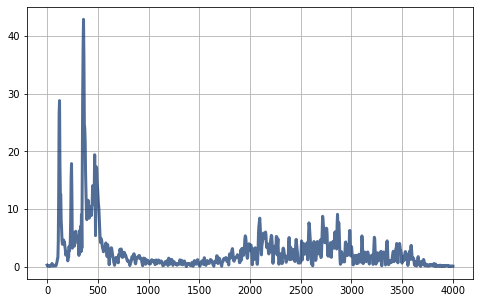

Writing sound.wav


In [ ]:
viz_and_play(rand_audiofiles[0])

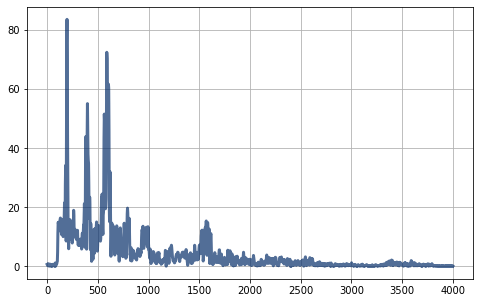

Writing sound.wav


In [ ]:
viz_and_play(rand_audiofiles[1])

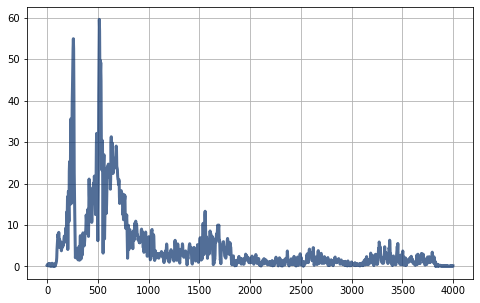

Writing sound.wav


In [ ]:
viz_and_play(rand_audiofiles[2])

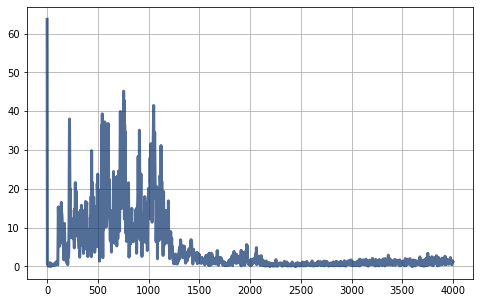

Writing sound.wav


In [ ]:
viz_and_play(rand_audiofiles[3])

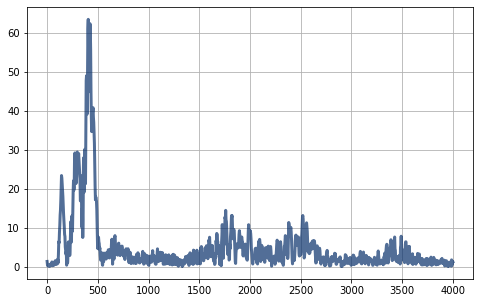

Writing sound.wav


In [ ]:
viz_and_play(rand_audiofiles[4])

## Creating dataframe

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [ ]:
df_audio = pd.DataFrame({'path':all_files})
#create 'label' column using first letter of filename
df_audio['label'] = df_audio['path'].apply(lambda x: int(x.split('/')[1][0])) 
df_audio.head()

,path,label
0,recordings/0_jackson_0.wav,0
1,recordings/0_jackson_1.wav,0
2,recordings/0_jackson_10.wav,0
3,recordings/0_jackson_11.wav,0
4,recordings/0_jackson_12.wav,0


In [ ]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
#checking class distribution
df_audio['label'].value_counts().sort_index()

0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: label, dtype: int64

In [ ]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)

In [ ]:
df_audio.head()

,path,label
766,recordings/3_yweweler_23.wav,3
182,recordings/0_yweweler_38.wav,0
1763,recordings/8_yweweler_20.wav,8
1814,recordings/9_jackson_21.wav,9
596,recordings/2_yweweler_6.wav,2


In [ ]:
X = df_audio['path']
y = df_audio['label']

<pre><font size=4>Train and Validation split</font></pre>

In [ ]:
#split the data into train and validation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=45)

# Preprocessing

All files are in the "WAV" format. We will read those raw data files using the librosa

In [ ]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [ ]:
#using load_wav function that was written above to get every wave. 
#saving in X_train_processed and X_test_processed
# X_train_processed/X_test_processed are dataframes with two columns(raw_data, duration) with same index as of X_train/y_train
X_train_processed = np.array(list(map(lambda i: load_wav(i, get_duration=True), X_train.values)))
X_test_processed = np.array(list(map(lambda i: load_wav(i, get_duration=True), X_test.values)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [ ]:
#create dataframe 
X_train_processed = pd.DataFrame({'raw_data': X_train_processed[:,0], 'duration':X_train_processed[:,1]})
X_test_processed = pd.DataFrame({'raw_data': X_test_processed[:,0], 'duration':X_test_processed[:,1]})

### Explore the distribution of Audio Duration feature to determine maxlen for padding and masking

In [ ]:
print(X_train_processed.shape)
X_train_processed.head()

(1400, 2)


,raw_data,duration
0,"[0.00011394074, 0.00012640332, 0.00012745972, ...",0.27678
1,"[0.015462314, 0.018172165, 0.01750962, 0.01515...",0.331519
2,"[0.0004158457, 0.00041390766, 7.270637e-05, -0...",0.292789
3,"[-0.00891809, -0.009839113, -0.009143287, -0.0...",0.344127
4,"[-0.009553918, -0.011437664, -0.011789859, -0....",0.659637


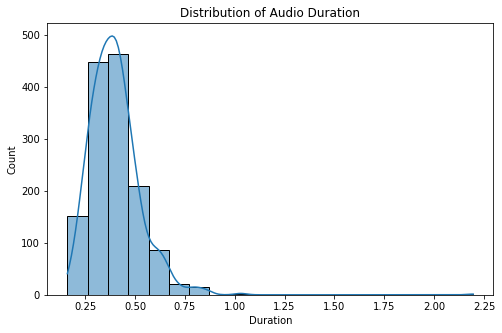

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

#plot the histogram of the duration for train
plt.figure(figsize=(8,5))
ax = sns.histplot(data = X_train_processed, x='duration', kde=True, bins=20)
ax.set(xlabel = 'Duration', ylabel='Count', title='Distribution of Audio Duration')
plt.show()

In [ ]:
counts, bin_edges = np.histogram(X_train_processed['duration'].values, bins = 20)
hist_df = pd.DataFrame({'count':counts, 'bin_edges':bin_edges[:-1]})
hist_df.head(10)

,count,bin_edges
0,152,0.161043
1,449,0.262787
2,464,0.364531
3,210,0.466274
4,86,0.568018
5,21,0.669762
6,15,0.771506
7,0,0.873249
8,2,0.974993
9,0,1.076737


In [ ]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
percentile_values = np.percentile(X_train_processed['duration'].values, np.arange(0,100,10))
percentiles = np.arange(0,100,10)
perdentile_df = pd.DataFrame({'percentiles': percentiles, 'values':percentile_values})
print('Exploring the Durations among Audio Files:')
perdentile_df

Exploring the Durations among Audio Files:


,percentiles,values
0,0,0.161043
1,10,0.258481
2,20,0.297433
3,30,0.329778
4,40,0.356916
5,50,0.389456
6,60,0.413288
7,70,0.444467
8,80,0.482685
9,90,0.553166


In [ ]:
#print 90 to 100 percentile values with step size of 1. 
percentile_values = np.percentile(X_train_processed['duration'].values, np.arange(90,101,1))
percentiles = np.arange(90,101,1)
perdentile_df = pd.DataFrame({'percentiles': percentiles, 'values':percentile_values})
print('Exploring the Durations among Audio Files:')
perdentile_df

Exploring the Durations among Audio Files:


,percentiles,values
0,90,0.553166
1,91,0.566983
2,92,0.579035
3,93,0.599511
4,94,0.611208
5,95,0.631601
6,96,0.643146
7,97,0.663574
8,98,0.695751
9,99,0.796012


<b>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640
</b>
<b>Pad with Zero if length of sequence is less than 17640 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [ ]:
import tensorflow as tf

In [ ]:
max_length  = 17640

In [ ]:
#create a function to return bool mask vector for every samples list
#real values: True, pad value: False
def mask_vector(x, maxlen):
    if len(x)<maxlen:
        mask = [True]*len(x) + [False]*(maxlen-len(x))
    else: 
        mask = [True]*maxlen
    return mask 

In [ ]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask
## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

X_train_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_processed['raw_data'].tolist(), maxlen = max_length, dtype='float32', padding='post', truncating='post')
X_train_mask = np.array(list(map(lambda x: mask_vector(x, max_length), X_train_processed['raw_data'].tolist())))

X_test_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_processed['raw_data'].tolist(), maxlen = max_length, dtype='float32', padding='post', truncating='post')
X_test_mask = np.array(list(map(lambda x: mask_vector(x, max_length), X_test_processed['raw_data'].tolist())))

### 1. Giving Raw data directly. 


Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 



In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [ ]:
X_train_pad_seq.shape, X_train_mask.shape

((1400, 17640), (1400, 17640))

In [ ]:
#LSTM takes 3-dim inputs so use np.newaxis to add a dimension
#note we are storing the new 3-dim input into new variables 
X_train_pad_seq_ = X_train_pad_seq[:,:,np.newaxis]
X_test_pad_seq_  = X_test_pad_seq[:,:,np.newaxis]

#convert y_train and y_test from series to arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
## as discussed above, please write the architecture of the model.
## you will have two input layers in your model (data input layer and mask input layer)
## make sure that you have defined the data type of masking layer as bool
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(45)

#inputs
input_layer = Input(shape = (17640,1))
masking_input_layer = Input(shape = (17640,), dtype = 'bool')

lstm = LSTM(128)(inputs=input_layer, mask=masking_input_layer)

dense = Dense(256, activation='relu')(lstm)

#output
output_layer =  Dense(10, activation='softmax')(dense)

model_1 = Model(inputs=[input_layer, masking_input_layer], outputs=output_layer)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          66560       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          33024       ['lstm[0][0]']               

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping, Callback
from sklearn.metrics import f1_score
import datetime
import os

In [ ]:
#refer - https://stackoverflow.com/questions/58391418/how-to-use-custom-metric-from-a-callback-with-earlystopping-or-modelcheckpoint

class custom_F1(Callback):
    
    def __init__(self, validation_data):
        super().__init__()
        self.x_test = validation_data[0]
        self.y_test = validation_data[1]

    def on_train_begin(self, epoch, logs={}):
        self.f1scores = []
        self.f1 = 0
        
    def on_epoch_end(self, epoch, logs={}):
        val_prob = np.array(self.model.predict(self.x_test))
        val_pred = np.argmax(val_prob, axis=1)
        val_true = self.y_test
        
        self.f1 = f1_score(val_true, val_pred, average='micro')
        self.f1scores.append(self.f1)

        logs['val_f1_score'] = self.f1
        
        print('val_f1_score:', self.f1)

In [ ]:
#callbacks 
checkpoint_cb_dict = {}
for i in range(1,5):
    path = f'checkpoints_model_{i}' + '/weights-{epoch:02d}-{val_f1_score:.4f}.hdf5'
    checkpoint_cb_dict[i] = ModelCheckpoint(filepath = path, monitor = 'val_f1_score', save_best_only=True, verbose=0, mode='max')
    
tensorboard_cb_dict = {}
for i in range(1,5):
    log_dir = os.path.join(f'logs_model_{i}','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_cb_dict[i] = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

reducelr_cb = ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=2, verbose=0, mode='max', min_delta=0.0001, min_lr=0.0001)

earlystop_cb = EarlyStopping(monitor='val_f1_score', min_delta=0.0001, patience=8, verbose=1, mode='max', restore_best_weights=True)

custom_f1_cb = custom_F1(validation_data = [[X_test_pad_seq_, X_test_mask], y_test])

In [ ]:
#for ModelCheckpoint we need to set _supports_tf_logs to False so that updated log dictionary is passed to the callback (https://stackoverflow.com/a/66869243/16567216)
checkpoint_cb_dict[1]._supports_tf_logs = False

#when using a metric as callback, the positioning of callbacks matters; keep the metric callbacks first then rest of the callbacks which are to access the metric value
callbacks_1 = [custom_f1_cb, checkpoint_cb_dict[1], tensorboard_cb_dict[1], reducelr_cb, earlystop_cb]

In [ ]:
#train your model
model_1.compile(optimizer='Adam',loss='sparse_categorical_crossentropy') 
history_1 = model_1.fit([X_train_pad_seq_, X_train_mask], y_train, epochs=25, validation_data = [[X_test_pad_seq_, X_test_mask], y_test], verbose=2, batch_size=100, callbacks = callbacks_1) 

Epoch 1/25
val_f1_score: 0.09666666666666666
14/14 - 36s - loss: 2.3036 - val_loss: 2.3027 - val_f1_score: 0.0967 - lr: 0.0010 - 36s/epoch - 3s/step
Epoch 2/25
val_f1_score: 0.09833333333333333
14/14 - 17s - loss: 2.3030 - val_loss: 2.3026 - val_f1_score: 0.0983 - lr: 0.0010 - 17s/epoch - 1s/step
Epoch 3/25
val_f1_score: 0.09833333333333333
14/14 - 24s - loss: 2.3029 - val_loss: 2.3026 - val_f1_score: 0.0983 - lr: 0.0010 - 24s/epoch - 2s/step
Epoch 4/25
val_f1_score: 0.10000000000000002
14/14 - 17s - loss: 2.3028 - val_loss: 2.3026 - val_f1_score: 0.1000 - lr: 0.0010 - 17s/epoch - 1s/step
Epoch 5/25
val_f1_score: 0.10000000000000002
14/14 - 18s - loss: 2.3027 - val_loss: 2.3025 - val_f1_score: 0.1000 - lr: 0.0010 - 18s/epoch - 1s/step
Epoch 6/25
val_f1_score: 0.10166666666666667
14/14 - 16s - loss: 2.3027 - val_loss: 2.3025 - val_f1_score: 0.1017 - lr: 0.0010 - 16s/epoch - 1s/step
Epoch 7/25
val_f1_score: 0.10166666666666667
14/14 - 18s - loss: 2.3027 - val_loss: 2.3025 - val_f1_score:

In [ ]:
results_1 = pd.DataFrame(history_1.history)
results_1.sort_values(by='val_f1_score', ascending=False, inplace=True)
results_1.head()

,loss,val_loss,val_f1_score,lr
14,2.302330,2.301787,0.118333,0.000250
19,2.301278,2.300633,0.116667,0.000100
17,2.301510,2.301124,0.116667,0.000125
22,2.300783,2.300450,0.113333,0.000100
20,2.301075,2.300195,0.113333,0.000100


Note:
- Blue represents Validation Curve 
- Orange represents Train Curve

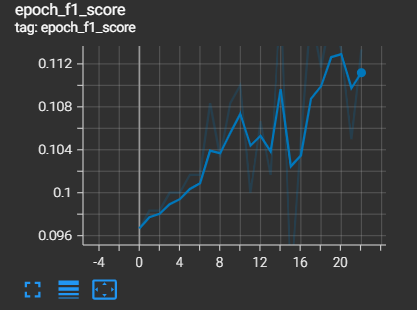

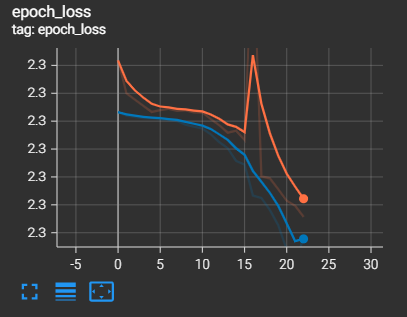

Observation:
- Validation F1 Score althought fluctuates but follows an increasing trend throughout.
- Train and Validation Loss decrease with each epoch, but the difference is negligibly small.
- Best Model is achieved at 65th epoch with performance on Validation as: F1 Score: 0.118, Loss: 2.301

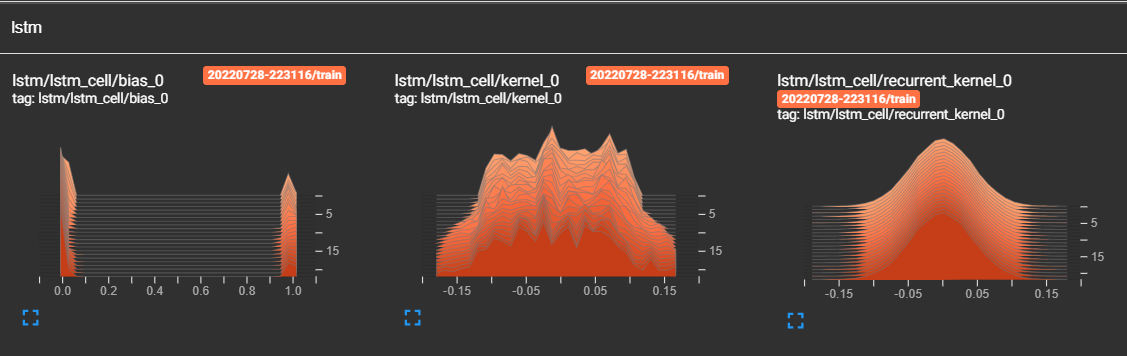

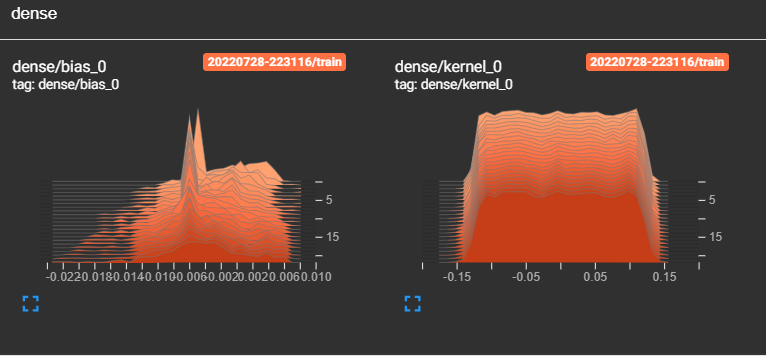

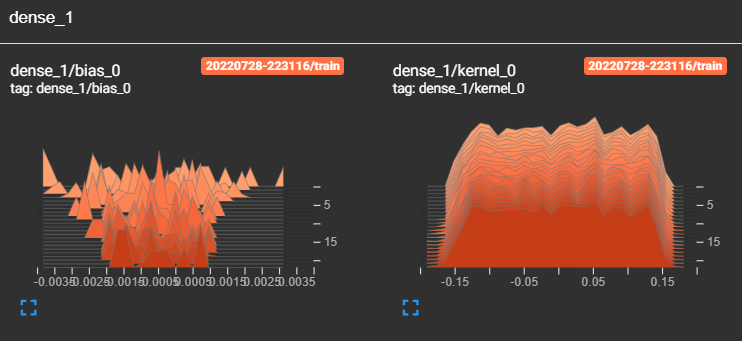

**Note**:
- x-axis: weight/bias values 
- y-axis: epochs
- z-axis: number of weights

**Observations**: 

LSTM Layer:
- Most Kernel(Wh) weights are in the range -0.09 to 0.09.
- Kernel weights distribution is finely adjusted throughout the epochs. 
- Recurrent Kernel(Wx) weights are centered around 0.
- Recurrent Kernel(Wx) weights distribution remains the same throughout epochs, no learning happening here.
- Most of the biases are valued 0 rest are valued at 1.
- Biases values remain 0 or 1, the distribution is finely adjusted throughout the epochs.

Dense Layer: 
- Most weights are in the range -0.10 and 0.10 for every epoch.
- The distribution of weights remains same throughout the epochs, no learning happening here.
- Most biases are in the range -0.01 to 0.003 for every epoch.
- The distribution of biases has conisderably changed through the epochs.
- By looking at the weights and bias distributions for this layer, we can say that only biases have been learned.

Dense_1 Layer (Output Layer): 
- Most weights are between -0.12 and 0.13 for every epoch.
- The distribution of weights remains same throughout the epochs, no learning happening here.
- The biases are spread all over, ranging from -0.003 to 0.003. 
- The distribution of biases has conisderably changed through the epochs.
- By looking at the weights and bias distributions for this layer, we can say that only biases have been learned.



### 2. Converting into spectrogram and giving spectrogram data as input  

We use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram


In [ ]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [ ]:
## use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram 
X_train_spectrogram = np.array(list(map(lambda x: convert_to_spectrogram(x), X_train_pad_seq)))
X_test_spectrogram = np.array(list(map(lambda x: convert_to_spectrogram(x), X_test_pad_seq)))


Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

In [ ]:
# building architecture of the model

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(45)

#input
input_layer = Input(shape = (64,35))

lstm = LSTM(128, return_sequences=True)(inputs=input_layer)

global_avg = GlobalAveragePooling1D()(lstm)

dense = Dense(256, activation='relu')(global_avg)

#output
output_layer =  Dense(10, activation='softmax')(dense)

model_2 = Model(inputs=input_layer, outputs=output_layer)
print(model_2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 128)           83968     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 119,562
Trainable params: 119,562
Non-trainable params: 0
_______________________________________________________

In [ ]:
#we need to redefine custom_f1 callback using spectrogram validation data
custom_f1_cb = custom_F1(validation_data = [X_test_spectrogram, y_test])
checkpoint_cb_dict[2]._supports_tf_logs = False

callbacks_2 = [custom_f1_cb, checkpoint_cb_dict[2], tensorboard_cb_dict[2], reducelr_cb, earlystop_cb]

In [ ]:
#compile and fit your model
model_2.compile(optimizer='Adam',loss='sparse_categorical_crossentropy') 
history_2 = model_2.fit(X_train_spectrogram, y_train, epochs=80, validation_data = [X_test_spectrogram, y_test], batch_size=100, verbose=2, callbacks = callbacks_2) 

Epoch 1/80
val_f1_score: 0.27
14/14 - 2s - loss: 2.2219 - val_loss: 2.1159 - val_f1_score: 0.2700 - lr: 0.0010 - 2s/epoch - 170ms/step
Epoch 2/80
val_f1_score: 0.3333333333333333
14/14 - 0s - loss: 2.0400 - val_loss: 1.9364 - val_f1_score: 0.3333 - lr: 0.0010 - 360ms/epoch - 26ms/step
Epoch 3/80
val_f1_score: 0.38666666666666666
14/14 - 0s - loss: 1.8744 - val_loss: 1.7764 - val_f1_score: 0.3867 - lr: 0.0010 - 292ms/epoch - 21ms/step
Epoch 4/80
val_f1_score: 0.41
14/14 - 0s - loss: 1.7339 - val_loss: 1.6608 - val_f1_score: 0.4100 - lr: 0.0010 - 282ms/epoch - 20ms/step
Epoch 5/80
val_f1_score: 0.46
14/14 - 0s - loss: 1.5889 - val_loss: 1.5030 - val_f1_score: 0.4600 - lr: 0.0010 - 268ms/epoch - 19ms/step
Epoch 6/80
val_f1_score: 0.5383333333333333
14/14 - 0s - loss: 1.4948 - val_loss: 1.4079 - val_f1_score: 0.5383 - lr: 0.0010 - 324ms/epoch - 23ms/step
Epoch 7/80
val_f1_score: 0.605
14/14 - 0s - loss: 1.3896 - val_loss: 1.3122 - val_f1_score: 0.6050 - lr: 0.0010 - 263ms/epoch - 19ms/step

In [ ]:
results_2 = pd.DataFrame(history_2.history)
results_2.sort_values(by='val_f1_score', ascending=False, inplace=True)
results_2.head()

,loss,val_loss,val_f1_score,lr
64,0.598852,0.688727,0.820000,0.0001
68,0.585316,0.671482,0.815000,0.0001
67,0.585996,0.673263,0.815000,0.0001
71,0.576055,0.670503,0.813333,0.0001
69,0.578999,0.670968,0.813333,0.0001


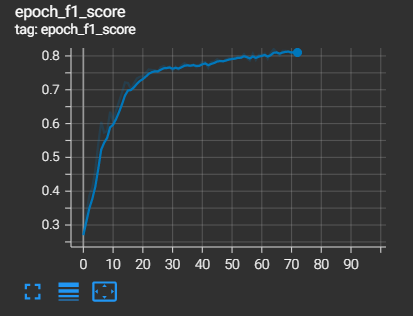

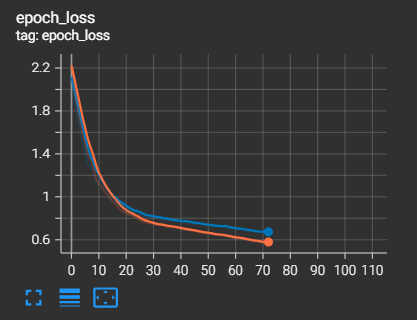

Observation:
- Validation F1 Score improves with each epoch, following and increasing trend throughout.
- Train and Validation Loss decrease with each epoch, indicating the model is learning well.
- Best Model is achieved at 65th epoch with performance on Validation as: F1 Score: 0.82, Loss: 0.68 

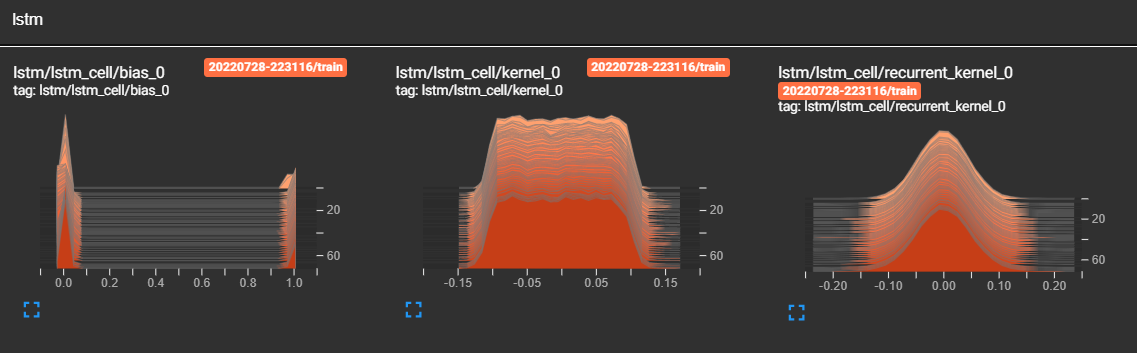

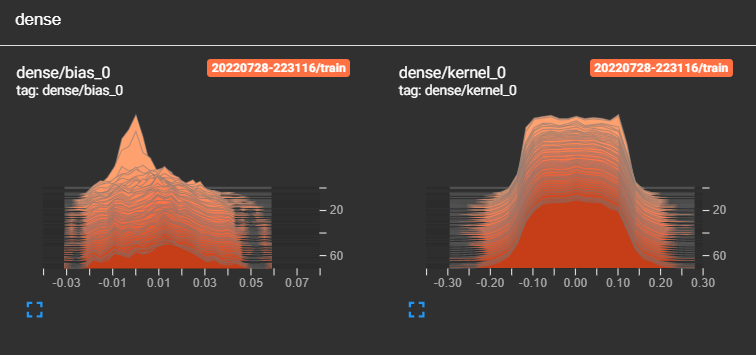

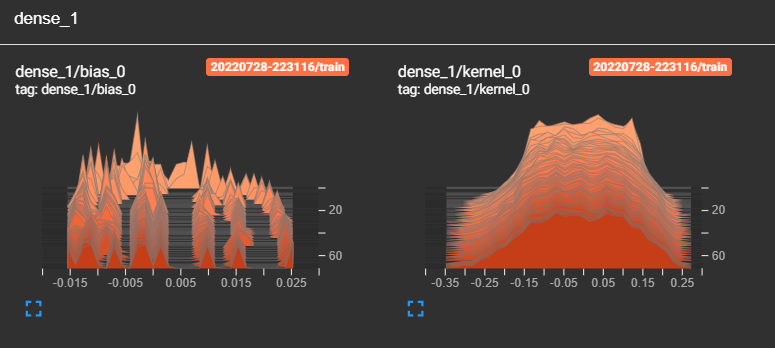

**Note**:

- x-axis: weight/bias values
- y-axis: epochs
- z-axis: number of weights

**Observations**:

LSTM Layer:
- Most Kernel(Wh) weights are in the range -0.09 to 0.09.
- Kernel weights distribution is finely adjusted throughout the epochs. 
- Recurrent Kernel(Wx) weights are in the range -0.20 to 0.20 centered around the mean 0.
- Recurrent Kernel(Wx) weights distribution remains the same throughout epochs, no learning happening here.
- Most of the biases are valued 0 rest are valued at 1.
- Biases values remain either 0 or 1, but the distribution is finely adjusted throughout the epochs.
- By looking at the distributions for this layer, we can say that only biases and kernel weights have been learned.

Dense Layer: 
- Most weights are in the range -0.10 and 0.10 for every epoch.
- The range of weights remains the same, but the distribution is finely adjusted throughout the epochs.
- Most biases are in the range -0.01 to 0.03 for every epoch.
- The distribution of biases has conisderably changed through the epochs.
- By looking at the weights and bias distributions for this layer, we can say that mostly biases have been learned and weights are finely tuned.

Dense_1 Layer (Output Layer):

- Most weights are between -0.15 and 0.15 and for every epoch.
- The distribution of weights is considerably changed throughout the epochs.
- The biases are spread all over, ranging from -0.015 to 0.025.
- The distribution of biases has conisderably changed throughout the epochs.
- By looking at the weights and bias distributions for this layer, we can say that both weights and bias have been learned.


### 3. Data augmentation with raw features 

Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.


In [ ]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [ ]:
#all 9 augmentations may be of different lengths not necessary they are the same length as the original file (samples list is the numeric representation of each audio file)
#the sample rate used is 22050 the first one

Next steps:

1. Split data 'df_audio' into train and test (80-20 split)

2. We have 2000 data points(1600 train points, 400 test points) 



In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df_audio['path'],df_audio['label'],random_state=45,test_size=0.2,stratify=df_audio['label'])

In [ ]:
# refer to flatten a 2D list : https://www.geeksforgeeks.org/python-ways-to-flatten-a-2d-list/
from itertools import chain

# generate_augmented_data returns a list of 9 augmented samples list for each audio file we pass
# 1600*9=14400; we get 14400 augmented samples in total when we pass all the audio files present in X_train 
X_train_aug = list(map(lambda x: generate_augmented_data(x), X_train.values))
#we get a list of lists of samples, to flatten it out we use the code below
X_train_aug = list(chain.from_iterable(X_train_aug))

#creating y_train_aug w.r.t X_train_aug
y_train_aug = np.array(list(map(lambda x: [x]*9, y_train.tolist())))
y_train_aug = y_train_aug.ravel()

In [ ]:
#create dataframe from augmented data
X_train_aug = pd.DataFrame({'aug_data': X_train_aug})
X_train_aug['duration'] = X_train_aug['aug_data'].apply(lambda x: len(x)/sample_rate) #we can also use lengths of samples directly here instead of duration

print(X_train_aug.shape)
X_train_aug.head()

(14400, 2)


,aug_data,duration
0,"[-4.4821245e-05, -9.792384e-05, -0.00013084589...",0.512880
1,"[-3.891717e-05, -9.452469e-05, -0.00013022157,...",0.512880
2,"[-4.350339e-05, -0.00010622868, -0.00013958628...",0.512880
3,"[-8.028066e-06, -3.7115544e-05, -6.274429e-05,...",0.359002
4,"[-1.2505185e-06, -2.6190057e-05, -5.0035313e-0...",0.359002


In [ ]:
#process audio files in X_test and create a dataframe; note: we don't augment test audio files 
X_test_processed = np.array(list(map(lambda i: load_wav(i, get_duration=True), X_test.values)))
y_test = np.array(y_test)

X_test_processed = pd.DataFrame({'raw_data': X_test_processed[:,0], 'duration': X_test_processed[:,1]})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


### Explore the distribution of Audio Duration feature to determine maxlen for padding and masking

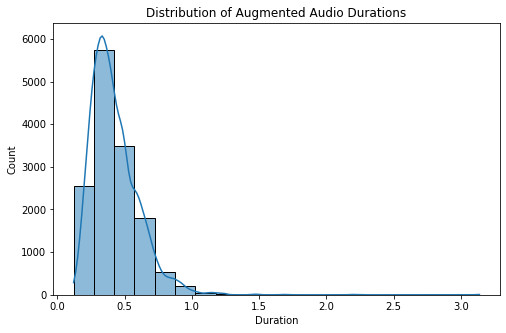

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.histplot(data = X_train_aug, x = 'duration', kde=True, bins=20) 
ax.set(xlabel = 'Duration', ylabel='Count', title='Distribution of Augmented Audio Durations')
plt.show()

In [ ]:
counts, bin_edges = np.histogram(X_train_aug['duration'].values, bins = 20)
hist_df = pd.DataFrame({'count':counts, 'bin_edges':bin_edges[:-1]})
hist_df.head()

,count,bin_edges
0,2556,0.121088
1,5748,0.271884
2,3480,0.422680
3,1794,0.573476
4,537,0.724272


In [ ]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
percentile_values = np.percentile(X_train_aug['duration'].values, np.arange(0,100,10))
percentiles = np.arange(0,100,10)
perdentile_df = pd.DataFrame({'percentiles': percentiles, 'values':percentile_values})
print('Exploring the Durations among Augmented Audio Files:')
perdentile_df

Exploring the Durations among Augmented Audio Files:


,percentiles,values
0,0,0.121088
1,10,0.237406
2,20,0.279810
3,30,0.318036
4,40,0.352880
5,50,0.391769
6,60,0.434630
7,70,0.486803
8,80,0.559029
9,90,0.654295


In [ ]:
#print 90 to 100 percentile values with step size of 1. 
percentile_values = np.percentile(X_train_aug['duration'].values, np.arange(90,101,1))
percentiles = np.arange(90,101,1)
perdentile_df = pd.DataFrame({'percentiles': percentiles, 'values':percentile_values})
print('Exploring the Durations among Augmented Audio Files:')
perdentile_df

Exploring the Durations among Augmented Audio Files:


,percentiles,values
0,90,0.654295
1,91,0.667710
2,92,0.681633
3,93,0.694344
4,94,0.715845
5,95,0.737878
6,96,0.769333
7,97,0.822721
8,98,0.873087
9,99,0.949664


<b>Based on our analysis 99 percentile values are less than 0.95sec so we will limit maximum length of X_train_processed and X_test_processed to 0.95 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.95*22050 = 20947
</b>
<b>Pad with Zero if length of sequence is less than 20947 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [ ]:
#99% of the Augmented Audio files have duration 0.95 so we keep the max sample length as 
max_length = int(0.95*sample_rate)
print(max_length)

20947


In [ ]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask
## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool
X_train_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_aug['aug_data'].tolist(), maxlen = max_length, dtype='float32', padding='post', truncating='post')
X_train_mask = np.array(list(map(lambda x: mask_vector(x, max_length), X_train_aug['aug_data'].tolist())))

X_test_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_processed['raw_data'].tolist(), maxlen = max_length, dtype='float32', padding='post', truncating='post')
X_test_mask = np.array(list(map(lambda x: mask_vector(x, max_length), X_test_processed['raw_data'].tolist())))

In [ ]:
X_train_pad_seq.shape, X_train_mask.shape, y_train_aug.shape, X_test_pad_seq.shape, X_test_mask.shape, y_test.shape

((14400, 20947), (14400, 20947), (14400,), (400, 20947), (400, 20947), (400,))

3. Performing augmentation only on X_train,passing each point of X_train to generate_augmented_data function.After augmentation we will get 14400 train points. 
4. Preprocess your X_test using load_wav function.
5. Convert the augmented_train_data and test_data to numpy arrays.
6. Perform padding and masking on augmented_train_data and test_data.
7. After padding define the model similar to model 1 and fit the data

In [ ]:
X_train_pad_seq_ = X_train_pad_seq[:,:,np.newaxis]
X_test_pad_seq_  = X_test_pad_seq[:,:,np.newaxis]

In [ ]:
## as discussed above, please write the architecture of the model.
## you will have two input layers in your model (data input layer and mask input layer)
## make sure that you have defined the data type of masking layer as bool
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(45)

input_layer = Input(shape = (20947,1))
masking_input_layer = Input(shape = (20947,), dtype = 'bool')

lstm = LSTM(64)(inputs=input_layer, mask=masking_input_layer)

dense = Dense(128, activation='relu')(lstm)

output_layer =  Dense(10, activation='softmax')(dense)
model_3 = Model(inputs=[input_layer, masking_input_layer], outputs=output_layer)
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20947, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20947)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           16896       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['lstm[0][0]']               

In [ ]:
custom_f1_cb = custom_F1(validation_data = [[X_test_pad_seq_, X_test_mask], y_test])
checkpoint_cb_dict[3]._supports_tf_logs = False

callbacks_3 = [custom_f1_cb, checkpoint_cb_dict[3], tensorboard_cb_dict[3], reducelr_cb, earlystop_cb]

In [ ]:
#train your model
model_3.compile(optimizer='Adam',loss='sparse_categorical_crossentropy') 
history_3 = model_3.fit([X_train_pad_seq_, X_train_mask], y_train_aug, epochs=25, validation_data = [[X_test_pad_seq_, X_test_mask], y_test], batch_size=100, verbose=2, callbacks = callbacks_3) 

Epoch 1/25
val_f1_score: 0.10000000000000002
144/144 - 103s - loss: 2.3030 - val_loss: 2.3028 - val_f1_score: 0.1000 - lr: 0.0010 - 103s/epoch - 718ms/step
Epoch 2/25
val_f1_score: 0.10000000000000002
144/144 - 94s - loss: 2.3029 - val_loss: 2.3026 - val_f1_score: 0.1000 - lr: 0.0010 - 94s/epoch - 650ms/step
Epoch 3/25
val_f1_score: 0.10000000000000002
144/144 - 94s - loss: 2.3028 - val_loss: 2.3026 - val_f1_score: 0.1000 - lr: 0.0010 - 94s/epoch - 656ms/step
Epoch 4/25
val_f1_score: 0.09
144/144 - 96s - loss: 2.3027 - val_loss: 2.3026 - val_f1_score: 0.0900 - lr: 5.0000e-04 - 96s/epoch - 664ms/step
Epoch 5/25
val_f1_score: 0.09
144/144 - 94s - loss: 2.3027 - val_loss: 2.3026 - val_f1_score: 0.0900 - lr: 5.0000e-04 - 94s/epoch - 653ms/step
Epoch 6/25
val_f1_score: 0.10000000000000002
144/144 - 94s - loss: 2.3026 - val_loss: 2.3026 - val_f1_score: 0.1000 - lr: 2.5000e-04 - 94s/epoch - 652ms/step
Epoch 7/25
val_f1_score: 0.095
144/144 - 94s - loss: 2.3026 - val_loss: 2.3026 - val_f1_scor

In [ ]:
results_3 = pd.DataFrame(history_3.history)
results_3.sort_values(by='val_f1_score', ascending=False, inplace=True)
results_3.head()

,loss,val_loss,val_f1_score,lr
0,2.303002,2.302785,0.1,0.001000
1,2.302884,2.302610,0.1,0.001000
2,2.302791,2.302594,0.1,0.001000
5,2.302627,2.302598,0.1,0.000250
8,2.302621,2.302601,0.1,0.000125


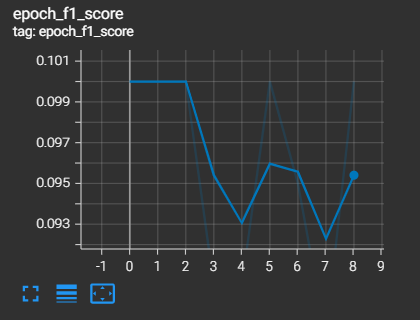

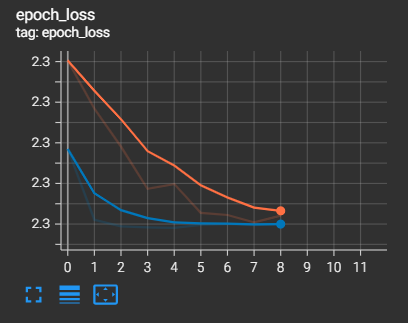

Observation:
- Validation F1 Score plateaus for the initial epochs then fluctuates. 
- Train and Validation Loss decrease with each epoch but the difference is negligibly small.
- Best Model is achieved at 1st epoch itself with performance on Validation as: F1 Score: 0.10, Loss: 2.30

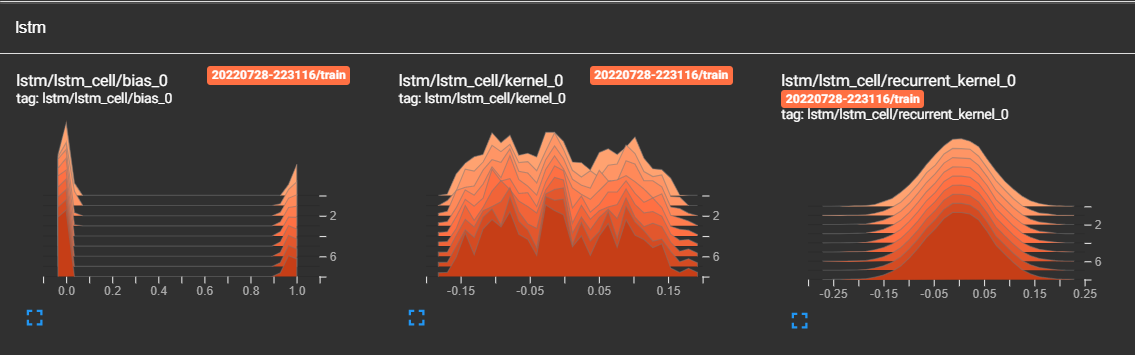

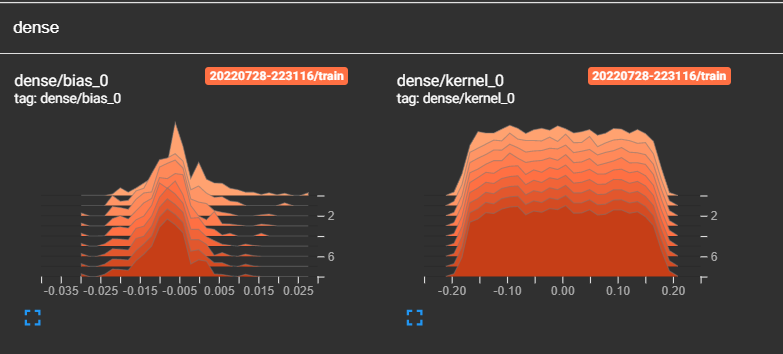

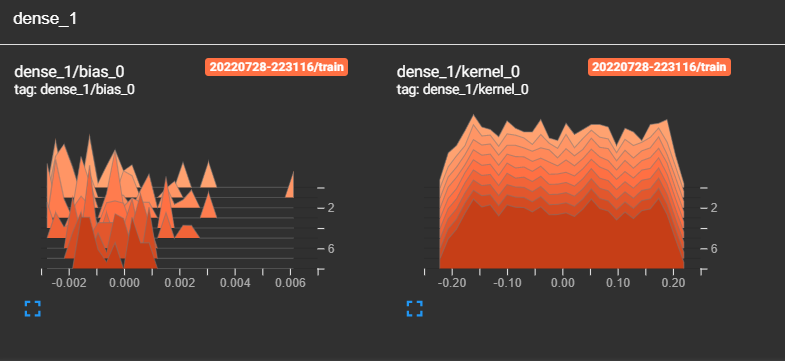

**Note**:
- x-axis: weight/bias values 
- y-axis: epochs
- z-axis: number of weights

**Observations**:

LSTM Layer:
- Most Kernel(Wh) weights are in the range -0.15 to 0.15.
- Kernel weights distribution is finely adjusted throughout the epochs. 
- Recurrent Kernel(Wx) weights are in the range -0.25 to 0.25 centered around the mean 0.
- Recurrent Kernel(Wx) weights distribution remains the same throughout epochs, no learning happening here.
- Most of the biases are valued 0 rest are valued at 1.
- Biases values remain either 0 or 1, but the distribution is finely adjusted throughout the epochs.
- By looking at the distributions for this layer, we can say that only biases and kernel weights have been learned.

Dense Layer: 
- Most weights are in the range -0.16 and 0.16 for every epoch.
- The distribution of weights remains same throughout the epochs.
- Most biases are in the range -0.015 to 0 for every epoch.
- The distribution of biases is finely adjusted through the epochs.
- By looking at the weights and bias distributions for this layer, we can say that only biases have been learned.

Dense_1 Layer (Output Layer): 
- Most weights are -0.16, 0.05, 0.17 and everyting in between for every epoch. 
- The weight distribution at last epoch is nearly the same as the 0th epoch, this says the network hasn't learned much.
- The biases are spread all over, ranging from -0.02 to 0.06. 
- The bias distribution has conisderably changed in the initial epochs.
- By looking at the distributions we can say that only biases have been learned.


### 4. Data augmentation with spectogram data

1. use convert_to_spectrogram and convert the padded data from train and test data to spectogram data.
2. The shape of train data will be 14400 x 64 x 35 and shape of test_data will be 400 x 64 x35
3. Define the model similar to model 2 and fit the data

In [ ]:
X_train_spectrogram = np.array(list(map(lambda x: convert_to_spectrogram(x), X_train_pad_seq)))
X_test_spectrogram = np.array(list(map(lambda x: convert_to_spectrogram(x), X_test_pad_seq)))

In [ ]:
X_train_spectrogram.shape, y_train_aug.shape, X_test_spectrogram.shape, y_test.shape

((14400, 64, 41), (14400,), (400, 64, 41), (400,))

In [ ]:
# write the architecture of the model
#print model.summary and make sure that it is following point 2 mentioned above
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(45)

input_layer = Input(shape = (64,41))

lstm = LSTM(64, return_sequences=True)(inputs=input_layer)

global_avg = GlobalAveragePooling1D()(lstm)

dense = Dense(128, activation='relu')(global_avg)

output_layer =  Dense(10, activation='softmax')(dense)

model_4 = Model(inputs=input_layer, outputs=output_layer)
print(model_4.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 41)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 64)            27136     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 36,746
Trainable params: 36,746
Non-trainable params: 0
_________________________________________________________

In [ ]:
custom_f1_cb = custom_F1(validation_data = [X_test_spectrogram, y_test])
checkpoint_cb_dict[4]._supports_tf_logs = False

callbacks_4 = [custom_f1_cb, checkpoint_cb_dict[4], tensorboard_cb_dict[4], reducelr_cb, earlystop_cb]

In [ ]:
#compile and fit your model.
model_4.compile(optimizer='Adam',loss='sparse_categorical_crossentropy') 
history_4 = model_4.fit(X_train_spectrogram, y_train_aug, epochs=50, validation_data = [X_test_spectrogram, y_test], batch_size=100, verbose=2, callbacks = callbacks_4) 

Epoch 1/50
val_f1_score: 0.4075
144/144 - 3s - loss: 2.0495 - val_loss: 1.7413 - val_f1_score: 0.4075 - lr: 0.0010 - 3s/epoch - 21ms/step
Epoch 2/50
val_f1_score: 0.5725
144/144 - 1s - loss: 1.5865 - val_loss: 1.3789 - val_f1_score: 0.5725 - lr: 0.0010 - 861ms/epoch - 6ms/step
Epoch 3/50
val_f1_score: 0.6225
144/144 - 1s - loss: 1.3460 - val_loss: 1.1494 - val_f1_score: 0.6225 - lr: 0.0010 - 878ms/epoch - 6ms/step
Epoch 4/50
val_f1_score: 0.6575
144/144 - 1s - loss: 1.1865 - val_loss: 1.0241 - val_f1_score: 0.6575 - lr: 0.0010 - 831ms/epoch - 6ms/step
Epoch 5/50
val_f1_score: 0.7325
144/144 - 1s - loss: 1.0755 - val_loss: 0.8797 - val_f1_score: 0.7325 - lr: 0.0010 - 874ms/epoch - 6ms/step
Epoch 6/50
val_f1_score: 0.7075
144/144 - 1s - loss: 0.9914 - val_loss: 0.8182 - val_f1_score: 0.7075 - lr: 0.0010 - 822ms/epoch - 6ms/step
Epoch 7/50
val_f1_score: 0.7675
144/144 - 1s - loss: 0.9333 - val_loss: 0.7032 - val_f1_score: 0.7675 - lr: 0.0010 - 865ms/epoch - 6ms/step
Epoch 8/50
val_f1_scor

In [ ]:
results_4 = pd.DataFrame(history_4.history)
results_4.sort_values(by='val_f1_score', ascending=False, inplace=True)
results_4.head()

,loss,val_loss,val_f1_score,lr
34,0.571866,0.477016,0.8525,0.0001
33,0.573622,0.484362,0.8525,0.0001
41,0.553352,0.477096,0.8500,0.0001
25,0.593784,0.495523,0.8500,0.0001
40,0.554859,0.472142,0.8475,0.0001


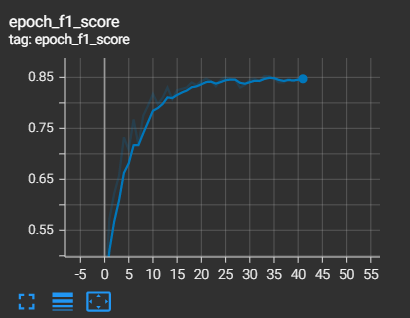

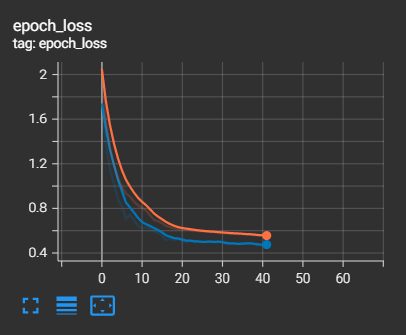

Observation:
- Validation F1 Score improves with each epoch, following and increasing trend throughout.
- Train and Validation Loss decrease with each epoch, indicating the model is learning well.
- Best Model is achieved at 35th epoch with performance on Validation as: F1 Score: 0.852, Loss: 0.477 

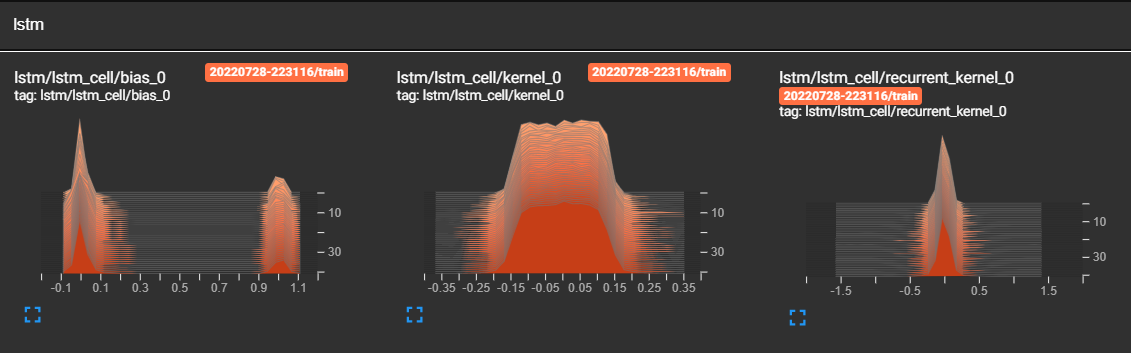

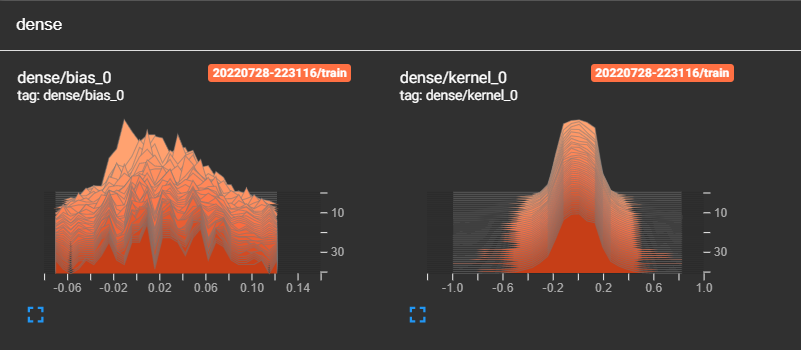

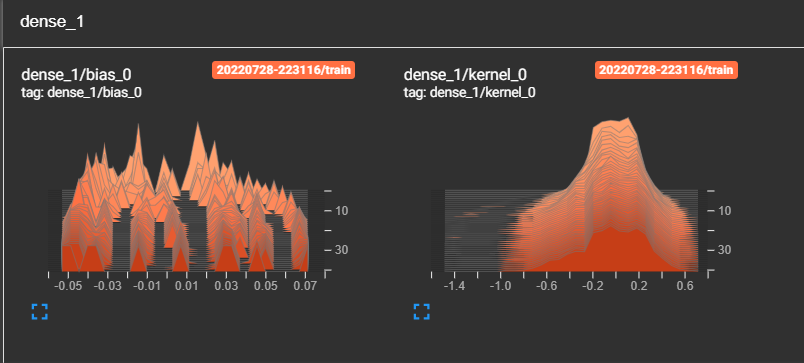

**Note**:
- x-axis: weight/bias values 
- y-axis: epochs
- z-axis: number of weights

**Observations**: 

LSTM Layer:
- Most Kernel(Wh) weights are in the range -0.10 to 0.10.
- Kernel weights distribution remains almost same throughout the epochs. 
- Recurrent Kernel(Wx) weights are in the range -0.50 to 0.50 centered around the mean 0.
- Recurrent Kernel(Wx) weights distribution remains the same throughout epochs, no learning happening here.
- Most of the biases are valued 0 rest are valued at 1.
- Biases values remain either 0 or 1, but the distribution is finely adjusted throughout the epochs.
- By looking at the distributions for this layer, we can say that only biases have been learned.

Dense Layer: 
- Most weights are in the range -0.15 and 0.15 for every epoch.
- The distribution of weights are finely adjusted through epochs.
- The biases are spread all over, ranging from -0.07 to 0.12. 
- The distribution of biases has conisderably changed through the epochs.
- By looking at the weights and bias distributions for this layer, we can say that biases have been learned and weights are finely tuned.

Dense_1 Layer (Output Layer):

- Most weights are between -0.2 and 0.2 and for every epoch.
- The distribution of weights is considerably changed throughout the epochs.
- The biases are spread all over, ranging from -0.05 to 0.07.
- The distribution of biases has conisderably changed throughout the epochs.
- By looking at the weights and bias distributions for this layer, we can say that both weights and bias have been learned.

# Conclusion

- The best performance is achieved on Augmented Data with Spectrogram format. 